# OpenRainER case study
This notebook shows a typical workflow for merging radar and CML data using the OpenRainER dataet. For details on how this data check the notebook:  
`./data/OpenRainER_cmlProcessing.ipynb`

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import poligrain as plg
import xarray as xr

from mergeplg import interpolate, merge

In [3]:
# Load processed data, resolution 5 minutes
ds_gauges = xr.open_dataset("./data/openrainer_AWS.nc")
ds_cmls = xr.open_dataset("./data/openrainer_CML.nc")
ds_rad = xr.open_dataset("./data/openrainer_RAD.nc")

# fix CML files
ds_cmls = ds_cmls.reduce(np.nanmean, dim="sublink_id")

# fix RG files
ds_gauges = ds_gauges.rename({"longitude": "lon", "latitude": "lat"})

# fix radar files
ds_rad = ds_rad.rename({"lon": "x", "lat": "y"})
ds_rad = ds_rad.rename({"rainfall_amount": "rainfall_radar"})
ys = [ds_rad.y.values,] * len(ds_rad.x.values)  # fmt: skip
xs = [ds_rad.x.values,] * len(ds_rad.y.values)  # fmt: skip
ds_rad["lat"] = (("y", "x"), np.array(ys).transpose())
ds_rad["lon"] = (("y", "x"), np.array(xs))
ds_rad = ds_rad.set_coords(["lon", "lat"])

# Transform rainfall rates to mm/h (from 15 min accumulated rainfall)
ds_gauges["rainfall_amount"] = ds_gauges.rainfall_amount * 60 / 15
ds_cmls["R"] = ds_cmls.R * 60 / 15
ds_rad["rainfall_radar"] = ds_rad.rainfall_radar * 60 / 15

# Project data

In [4]:
# UTM32N: https://epsg.io/32632
ref_str = "EPSG:32632"

In [5]:
ds_gauges.coords["x"], ds_gauges.coords["y"] = plg.spatial.project_point_coordinates(
    ds_gauges.lon, ds_gauges.lat, ref_str
)

In [6]:
# For CML
(
    ds_cmls.coords["site_0_x"],
    ds_cmls.coords["site_0_y"],
) = plg.spatial.project_point_coordinates(
    ds_cmls.site_0_lon, ds_cmls.site_0_lat, ref_str
)
(
    ds_cmls.coords["site_1_x"],
    ds_cmls.coords["site_1_y"],
) = plg.spatial.project_point_coordinates(
    ds_cmls.site_1_lon, ds_cmls.site_1_lat, ref_str
)

# Midpoint
ds_cmls["x"] = (ds_cmls.site_0_x + ds_cmls.site_1_x) / 2
ds_cmls["y"] = (ds_cmls.site_0_y + ds_cmls.site_1_y) / 2

In [7]:
# Projected radar coords
ds_rad.coords["x_grid"], ds_rad.coords["y_grid"] = (
    plg.spatial.project_point_coordinates(ds_rad.lon, ds_rad.lat, ref_str)
)

# Estimate rainfall fields

In [8]:
# Define variogram parameters used by kriging
variogram_parameters = {"sill": 1, "range": 30000, "nugget": 0.3}
variogram_model = "spherical"

# Number of neighbours to use for interpolation
nnear = 8

In [9]:
# IDW interpolation
interpolator = interpolate.InterpolateIDW(
    ds_grid=ds_rad.rainfall_radar,
    ds_cmls=ds_cmls,
    nnear=nnear,
)

rainfall = []
for time in ds_cmls.time.data:
    rainfall.append(
        interpolator(
            da_cmls=ds_cmls.sel(time=time).R,
        )
    )
ds_rad["rainfall_interpolateIDW"] = xr.concat(rainfall, dim="time")

In [10]:
# Kriging interpolation
interpolator = interpolate.InterpolateOrdinaryKriging(
    ds_grid=ds_rad.rainfall_radar,
    ds_cmls=ds_cmls,
    full_line=False,
    variogram_parameters=variogram_parameters,
    nnear=nnear,
)

rainfall = []
for time in ds_cmls.time.data:
    rainfall.append(
        interpolator(
            da_cmls=ds_cmls.sel(time=time).R,
        )
    )
ds_rad["rainfall_interpolateBKpoint"] = xr.concat(rainfall, dim="time")

In [11]:
# Block kriging interpolation
interpolator = interpolate.InterpolateOrdinaryKriging(
    ds_grid=ds_rad.rainfall_radar,
    ds_cmls=ds_cmls,
    full_line=True,
    variogram_parameters=variogram_parameters,
    nnear=nnear,
)

rainfall = []
for time in ds_cmls.time.data:
    rainfall.append(
        interpolator(
            da_cmls=ds_cmls.sel(time=time).R,
        )
    )
ds_rad["rainfall_interpolateBKline"] = xr.concat(rainfall, dim="time")

In [12]:
# IDW additive adjust
merger = merge.MergeDifferenceIDW(
    ds_rad=ds_rad.rainfall_radar,
    ds_cmls=ds_cmls,
    method="additive",
    nnear=nnear,
)

rainfall = []
for time in ds_cmls.time.data:
    rainfall.append(
        merger(
            da_rad=ds_rad.sel(time=time).rainfall_radar,
            da_cmls=ds_cmls.R.sel(time=time),
        )
    )
ds_rad["rainfall_additiveIDW"] = xr.concat(rainfall, dim="time")

In [13]:
# Kriging additive adjust
merger = merge.MergeDifferenceOrdinaryKriging(
    ds_rad=ds_rad.rainfall_radar,
    ds_cmls=ds_cmls,
    full_line=False,
    variogram_parameters=variogram_parameters,
    nnear=nnear,
    method="additive",
)

rainfall = []
for time in ds_cmls.time.data:
    rainfall.append(
        merger(
            ds_rad.sel(time=time).rainfall_radar,
            da_cmls=ds_cmls.sel(time=time).R,
        )
    )
ds_rad["rainfall_additiveBKpoint"] = xr.concat(rainfall, dim="time")

In [14]:
# Block kriging multiplicative adjust
merger = merge.MergeDifferenceOrdinaryKriging(
    ds_rad=ds_rad.rainfall_radar,
    ds_cmls=ds_cmls,
    full_line=True,
    variogram_parameters=variogram_parameters,
    nnear=nnear,
    method="multiplicative",
)

rainfall = []
for time in ds_cmls.time.data:
    rainfall.append(
        merger(
            ds_rad.sel(time=time).rainfall_radar,
            da_cmls=ds_cmls.sel(time=time).R,
        )
    )
ds_rad["rainfall_multiplicativeBKline"] = xr.concat(rainfall, dim="time")

In [15]:
# Block kriging with external drift
merger = merge.MergeKrigingExternalDrift(
    ds_rad=ds_rad.rainfall_radar,
    ds_cmls=ds_cmls,
    full_line=True,
    variogram_parameters=variogram_parameters,
    nnear=nnear,
)

rainfall = []
for time in ds_cmls.time.data:
    rainfall.append(
        merger(
            ds_rad.sel(time=time).rainfall_radar,
            da_cmls=ds_cmls.sel(time=time).R,
        )
    )
ds_rad["rainfall_KED"] = xr.concat(rainfall, dim="time")

# Plot rainfall fields

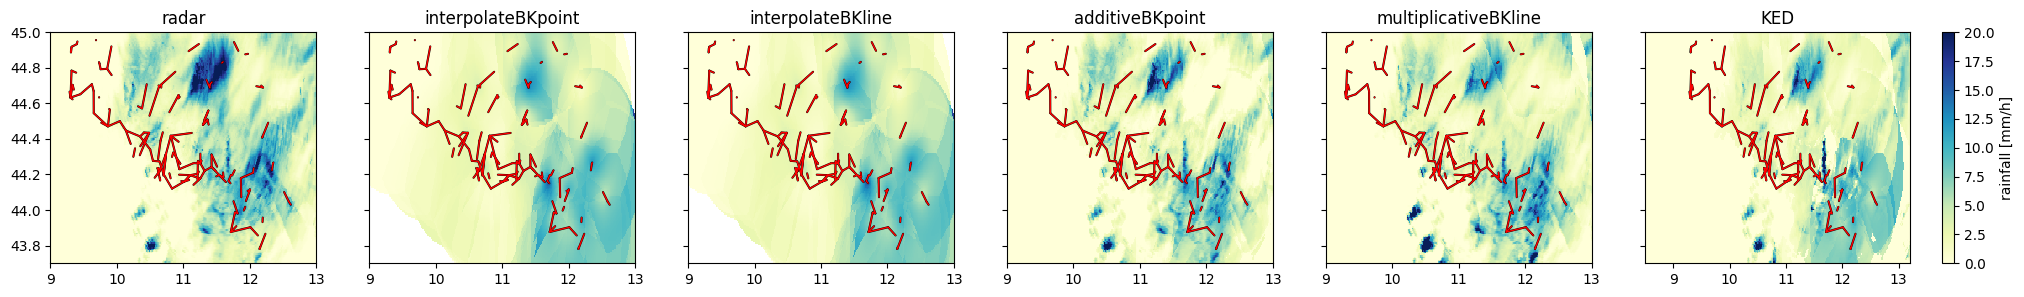

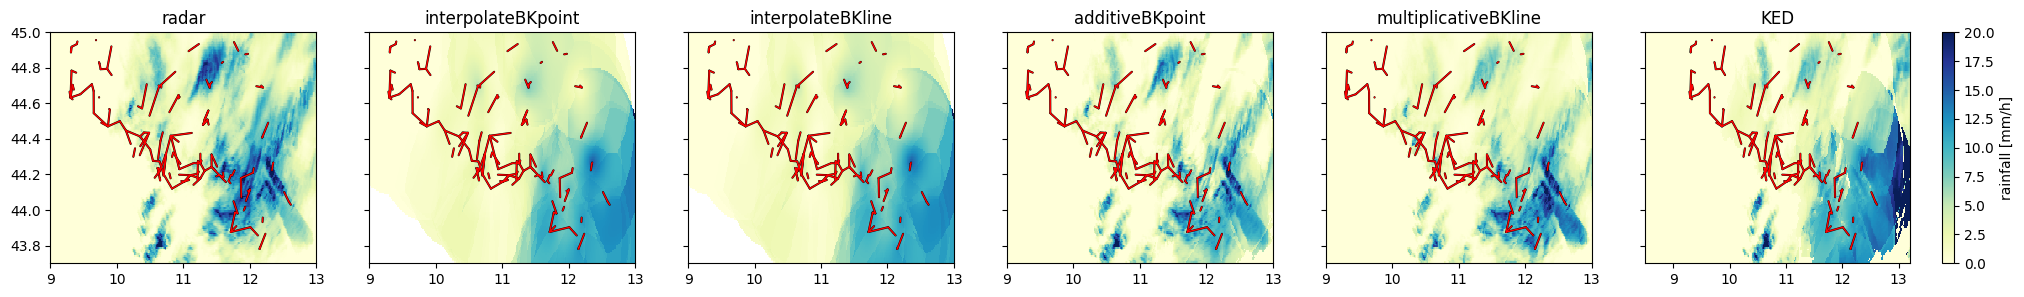

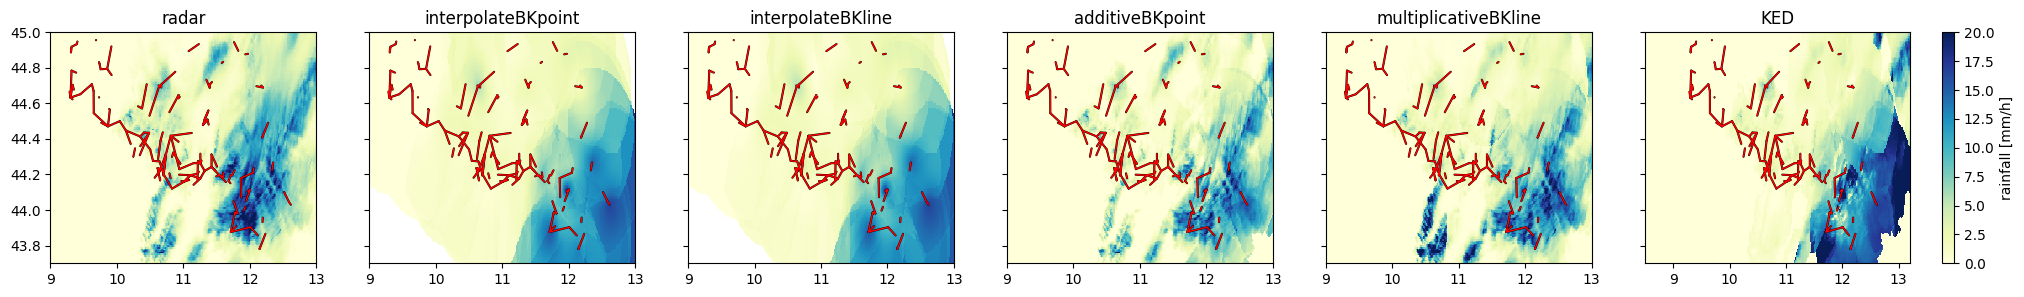

In [16]:
vmax = 20  # max color
# Time interval to plot
time_start = "2022-09-17T09:45"
time_end = "2022-09-17T10:15"

# Rainfall fields to plot
rainfall_fields = [
    "rainfall_radar",
    # "rainfall_interpolateIDW",
    "rainfall_interpolateBKpoint",
    "rainfall_interpolateBKline",
    # "rainfall_additiveIDW",
    "rainfall_additiveBKpoint",
    "rainfall_multiplicativeBKline",
    "rainfall_KED",
]

for time in ds_cmls.sel(time=slice(time_start, time_end)).time:
    fig, ax = plt.subplots(1, len(rainfall_fields), figsize=(30, 3), sharey=True)
    for i, rainfall_field in enumerate(rainfall_fields):
        # Plot rainfall field
        im = ax[i].pcolormesh(
            ds_rad.lon,
            ds_rad.lat,
            ds_rad[rainfall_field].sel(time=time),
            vmin=0,
            vmax=vmax,
            cmap="YlGnBu",
        )

        # Plot postion CMLs
        plg.plot_map.plot_lines(
            ds_cmls,
            use_lon_lat=True,
            ax=ax[i],
            line_color="r",
        )

        ax[i].set_title(rainfall_field.split("_")[1])

    for p in range(5):
        ax[p].set_xlim(9, 13)
        ax[p].set_ylim(43.7, 45)

    clb = fig.colorbar(im, ax=ax, location="right", anchor=(-0.25, 1.0))
    clb.ax.set_ylabel("rainfall [mm/h]")
    plt.show()

# Compare to rain gauges

In [17]:
get_grid_at_points = plg.spatial.GridAtPoints(
    da_gridded_data=ds_rad,
    da_point_data=ds_gauges,
    nnear=1,
    stat="best",
)

# Sample rainfall fields
for rainfall_field in rainfall_fields:
    ds_gauges[rainfall_field] = get_grid_at_points(
        da_gridded_data=ds_rad[rainfall_field],
        da_point_data=ds_gauges.rainfall_amount,
    )

In [18]:
# Multiplicative merging estimate has outliers, this extracts max values
max_est = 0
for rainfall_field in rainfall_fields:
    if rainfall_field != "rainfall_multiplicativeBKline":
        max_est_try = ds_gauges[rainfall_field].to_numpy().max()
        if max_est_try > max_est:
            max_est = max_est_try

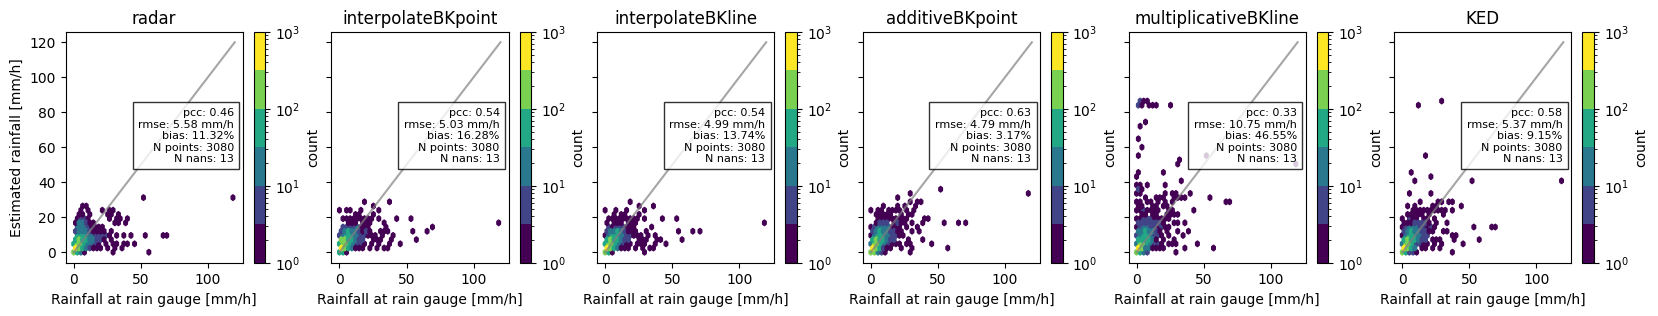

In [19]:
# Plot
threshold = 0.1  # Estimates below this are ignored
ground_truth = ds_gauges.rainfall_amount.data.flatten()

fig, ax = plt.subplots(
    1, len(rainfall_fields), figsize=(20, 3), sharey=True, sharex=True
)
for i, rainfall_field in enumerate(rainfall_fields):
    # Get predictions at test gauges
    predicted = ds_gauges[rainfall_field].to_numpy().flatten()

    # Set large values to max_est
    predicted[predicted > max_est] = max_est

    # plotting the scatter density plots
    hx = plg.validation.plot_hexbin(
        ground_truth,
        predicted,
        ref_thresh=threshold,
        est_thresh=threshold,
        ax=ax[i],
    )

    ax[i].set_title(rainfall_field.split("_")[1])
    if i == 0:
        ax[i].set_ylabel("Estimated rainfall [mm/h]")
    else:
        ax[i].set_ylabel("")

    ax[i].set_xlabel("Rainfall at rain gauge [mm/h]")

    rainfall_metrics = plg.validation.calculate_rainfall_metrics(
        reference=ground_truth,
        estimate=predicted,
        ref_thresh=threshold,
        est_thresh=threshold,
    )

    # adding metrics to the plot for subplot 0
    plotted_metrics = (
        f"pcc: {np.round(rainfall_metrics['pearson_correlation_coefficient'], 2)}\n"
        f"rmse: {np.round(rainfall_metrics['root_mean_square_error'], 2)} mm/h\n"
        f"bias: {np.round(rainfall_metrics['percent_bias'], 2)}%\n"
        f"N points: {rainfall_metrics['N_all']}\n"
        f"N nans: {rainfall_metrics['N_nan']}"
    )

    ax[i].text(
        0.95,
        0.55,
        plotted_metrics,
        fontsize=8,
        transform=ax[i].transAxes,
        verticalalignment="center",
        horizontalalignment="right",
        bbox={"facecolor": "white", "alpha": 0.8},
    )